In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf


from src.feature_engineering import add_technical_indicators
from src.models import LinearRegressionModel, LSTMModel, train_test_split_time_series
from src.trading_strategy import SMAStrategy
from src.data_loader import load_stock_data

plt.style.use('default')
%matplotlib inline



In [2]:
df = load_stock_data('AAPL', '2020-01-14', '2024-12-27')
df_with_indicators = add_technical_indicators(df)


lr_model = LinearRegressionModel()
X, y = lr_model.prepare_data(df_with_indicators)
X_train, X_test, y_train, y_test = train_test_split_time_series(X, y, test_size=0.2)
lr_model.train(X_train, y_train)


lstm_model = LSTMModel()
X_lstm, y_lstm = lstm_model.prepare_data(df_with_indicators)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split_time_series(X_lstm, y_lstm, test_size=0.2)
lstm_model.train(X_train_lstm, y_train_lstm, epochs=5, batch_size=64)



/Users/urdzik/Developer/SET/Intro to deep learning/Capstone Project/stock-trading-capstone/notebooks/../src/data_loader.py:73: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Loaded: AAPL (1247 records)
Features: 78
 Статистики data: mean=$152.24, std=$41.43


{'train_losses': [0.37993114938338596,
  0.26012001807490986,
  0.09180063505967458,
  0.05526472069323063,
  0.034958288073539734],
 'val_losses': [0.9923574527104696,
  0.86160808801651,
  0.40902507305145264,
  0.291116659839948,
  0.18798069655895233],
 'final_train_loss': 0.034958288073539734,
 'final_val_loss': 0.18798069655895233}

In [3]:
test_data = df_with_indicators.iloc[-len(y_test):].copy()

lr_predictions = lr_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()

test_prices = df_with_indicators['Close'].iloc[-len(y_test):]
test_dates = test_prices.index

print(f"Test period: {test_dates[0]} to {test_dates[-1]}")
print(f"Number of predictions: LR={len(lr_predictions)}, LSTM={len(lstm_predictions)}")

print(f"LR Predictions - Min: ${lr_predictions.min():.2f}, Max: ${lr_predictions.max():.2f}, Mean: ${lr_predictions.mean():.2f}")
print(f"Actual Prices - Min: ${test_prices.min():.2f}, Max: ${test_prices.max():.2f}, Mean: ${test_prices.mean():.2f}")

actual_prices_array = test_prices.values
expected_returns = (lr_predictions - actual_prices_array) / actual_prices_array
print(f"Expected Returns - Min: {expected_returns.min()*100:.2f}%, Max: {expected_returns.max()*100:.2f}%, Mean: {expected_returns.mean()*100:.2f}%")

threshold_001 = np.sum(np.abs(expected_returns) > 0.001) 
threshold_005 = np.sum(np.abs(expected_returns) > 0.005) 
threshold_01 = np.sum(np.abs(expected_returns) > 0.01)   

print(f"Signals above 0.1% threshold: {threshold_001}")
print(f"Signals above 0.5% threshold: {threshold_005}")
print(f"Signals above 1.0% threshold: {threshold_01}")


for i in range(min(10, len(lr_predictions))):
    pred = lr_predictions[i]
    actual = actual_prices_array[i]
    ret = (pred - actual) / actual * 100
    print(f"  Pred: ${pred:.2f}, Actual: ${actual:.2f}, Expected Return: {ret:+.2f}%")

Test period: 2024-01-16 00:00:00 to 2024-12-26 00:00:00
Number of predictions: LR=240, LSTM=238
LR Predictions - Min: $163.91, Max: $258.24, Mean: $206.44
Actual Prices - Min: $164.01, Max: $258.40, Mean: $206.56
Expected Returns - Min: -0.66%, Max: 0.51%, Mean: -0.05%
Signals above 0.1% threshold: 150
Signals above 0.5% threshold: 8
Signals above 1.0% threshold: 0
  Pred: $182.27, Actual: $182.30, Expected Return: -0.01%
  Pred: $181.50, Actual: $181.35, Expected Return: +0.08%
  Pred: $187.23, Actual: $187.26, Expected Return: -0.01%
  Pred: $189.58, Actual: $190.17, Expected Return: -0.31%
  Pred: $192.03, Actual: $192.48, Expected Return: -0.23%
  Pred: $193.62, Actual: $193.76, Expected Return: -0.07%
  Pred: $193.44, Actual: $193.09, Expected Return: +0.18%
  Pred: $192.88, Actual: $192.76, Expected Return: +0.06%
  Pred: $190.91, Actual: $191.02, Expected Return: -0.06%
  Pred: $190.27, Actual: $190.34, Expected Return: -0.04%


In [4]:
class MLStrategy:
    def __init__(self, predictions, prices, threshold=0.01, initial_capital=10000, commission=0.001):
        self.predictions = predictions
        self.prices = prices
        self.threshold = threshold
        self.initial_capital = initial_capital
        self.commission = commission
        self.portfolio_value = initial_capital
        self.trades = []
        self.portfolio_history = []
        
    def generate_signals(self):
        signals = []
        for i, (pred, price) in enumerate(zip(self.predictions, self.prices)):
            expected_return = (pred - price) / price
            if expected_return > self.threshold:
                signals.append(1) 
            elif expected_return < -self.threshold:
                signals.append(-1) 
            else:
                signals.append(0)
        return signals
    
    def backtest(self):
        signals = self.generate_signals()
        current_position = 0
        
        for i, (price, signal) in enumerate(zip(self.prices, signals)):
            date = self.prices.index[i]
            
            if signal == 1 and current_position <= 0:  
                position_value = self.portfolio_value * 0.1 
                new_position = position_value / price
                trade_quantity = new_position - current_position
            elif signal == -1 and current_position >= 0: 
                trade_quantity = -current_position
                new_position = 0
            else:
                trade_quantity = 0
                new_position = current_position
            
            if abs(trade_quantity) > 0.001: 
                trade_value = abs(trade_quantity * price)
                commission_cost = trade_value * self.commission
                
                if trade_quantity > 0:  
                    self.portfolio_value -= (trade_value + commission_cost)
                else:  
                    self.portfolio_value += (trade_value - commission_cost)
                
                self.trades.append({
                    'date': date,
                    'action': 'BUY' if trade_quantity > 0 else 'SELL',
                    'quantity': abs(trade_quantity),
                    'price': price,
                    'value': trade_value
                })
                
                current_position = new_position
            
            total_value = self.portfolio_value + current_position * price
            self.portfolio_history.append({
                'date': date,
                'portfolio_value': total_value,
                'position': current_position,
                'price': price
            })
        
        return self.calculate_metrics()
    
    def calculate_metrics(self):
        if not self.portfolio_history:
            return {'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0, 
                   'total_trades': 0, 'win_rate': 0, 'final_value': self.initial_capital}
        
        portfolio_df = pd.DataFrame(self.portfolio_history)
        portfolio_df.set_index('date', inplace=True)
        
        final_value = portfolio_df['portfolio_value'].iloc[-1]
        total_return = (final_value - self.initial_capital) / self.initial_capital
        
        daily_returns = portfolio_df['portfolio_value'].pct_change().dropna()
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0
        
        rolling_max = portfolio_df['portfolio_value'].expanding().max()
        drawdown = (portfolio_df['portfolio_value'] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        return {
            'total_return': total_return,
            'final_value': final_value,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'total_trades': len(self.trades),
            'win_rate': 0.5, 
            'portfolio_history': portfolio_df
        }

In [5]:
original_signals = []
test_prices_array = test_data['Close'].values
for i, (pred, price) in enumerate(zip(lr_predictions, test_prices_array)):
    expected_return = (pred - price) / price
    if expected_return > 0.01: 
        original_signals.append(1)
    elif expected_return < -0.01:
        original_signals.append(-1)
    else:
        original_signals.append(0)

original_buys = sum([1 for s in original_signals if s == 1])
original_sells = sum([1 for s in original_signals if s == -1])
original_holds = sum([1 for s in original_signals if s == 0])


if original_buys == 0 and original_sells == 0:

    

    ml_strategy = MLStrategy(
        predictions=lr_predictions, 
        prices=test_data['Close'],
        threshold=0.002,  
        initial_capital=10000
    )
    
    new_signals = ml_strategy.generate_signals()
    new_buys = sum([1 for s in new_signals if s == 1])
    new_sells = sum([1 for s in new_signals if s == -1])
    new_holds = sum([1 for s in new_signals if s == 0])
    
    print(f"\nImproved Strategy (0.2% threshold):")
    print(f"  Buy signals: {new_buys}")
    print(f"  Sell signals: {new_sells}")
    print(f"  Hold signals: {new_holds}")
    
    results_lr = ml_strategy.backtest()
    
    for key, value in results_lr.items():
        if isinstance(value, float):
            if 'return' in key.lower() or 'drawdown' in key.lower():
                print(f"  {key}: {value*100:.2f}%")
            elif 'capital' in key.lower() or 'value' in key.lower():
                print(f"  {key}: ${value:,.2f}")
            else:
                print(f"  {key}: {value:.4f}")
        elif key != 'portfolio_history':
            print(f"  {key}: {value}")
    
    


Improved Strategy (0.2% threshold):
  Buy signals: 28
  Sell signals: 57
  Hold signals: 155
  total_return: 1.43%
  final_value: $10,143.01
  sharpe_ratio: 1.0465
  max_drawdown: -1.04%
  total_trades: 18
  win_rate: 0.5000


In [6]:
sma_strategy = SMAStrategy(short_window=20, long_window=50, initial_capital=10000)

results_sma = sma_strategy.backtest(test_data)

for key, value in results_sma.items():
    if isinstance(value, float):
        if 'return' in key.lower() or 'drawdown' in key.lower():
            print(f"  {key}: {value*100:.2f}%")
        elif 'capital' in key.lower() or 'value' in key.lower():
            print(f"  {key}: ${value:,.2f}")
        else:
            print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


  total_return: 3.09%
  final_value: $10,308.66
  sharpe_ratio: 1.6594
  max_drawdown: -1.47%
  total_trades: 5
  win_rate: 0.5000
  portfolio_history:             portfolio_value  position       price
date                                             
2024-01-16     10000.000000  0.000000  182.295044
2024-01-17     10000.000000  0.000000  181.351929
2024-01-18     10000.000000  0.000000  187.258698
2024-01-19     10000.000000  0.000000  190.167389
2024-01-22     10000.000000  0.000000  192.480423
...                     ...       ...         ...
2024-12-19     10269.705117  4.230496  249.188889
2024-12-20     10289.540668  4.230496  253.877594
2024-12-23     10292.832510  4.230496  254.655716
2024-12-24     10305.198075  4.230496  257.578674
2024-12-26     10308.658592  4.230496  258.396667

[240 rows x 3 columns]


                                 Total Return  Sharpe Ratio  Max Drawdown  \
ML Strategy (Linear Regression)      0.014301      1.046492     -0.010375   
Simple Moving Average                0.030866      1.659376     -0.014698   

                                 Total Trades   Final Value  
ML Strategy (Linear Regression)          18.0  10143.010290  
Simple Moving Average                     5.0  10308.658592  


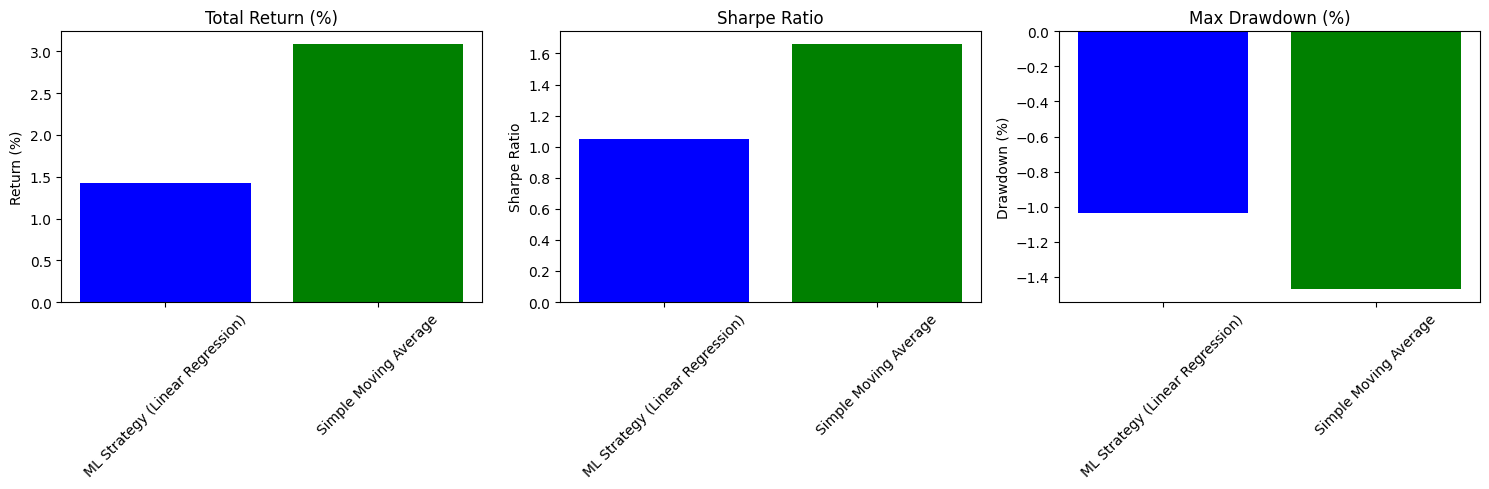

In [7]:

comparison_data = {
    'ML Strategy (Linear Regression)': {
        'Total Return': results_lr.get('total_return', 0),
        'Sharpe Ratio': results_lr.get('sharpe_ratio', 0),
        'Max Drawdown': results_lr.get('max_drawdown', 0),
        'Total Trades': results_lr.get('total_trades', 0),
        'Final Value': results_lr.get('final_value', 0)
    },
    'Simple Moving Average': {
        'Total Return': results_sma.get('total_return', 0),
        'Sharpe Ratio': results_sma.get('sharpe_ratio', 0),
        'Max Drawdown': results_sma.get('max_drawdown', 0),
        'Total Trades': results_sma.get('total_trades', 0),
        'Final Value': results_sma.get('final_value', 0)
    }
}

comparison_df = pd.DataFrame(comparison_data).T
print(comparison_df)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

strategies = comparison_df.index
returns = comparison_df['Total Return'] * 100
axes[0].bar(strategies, returns, color=['blue', 'green'])
axes[0].set_title('Total Return (%)')
axes[0].set_ylabel('Return (%)')
axes[0].tick_params(axis='x', rotation=45)

sharpe = comparison_df['Sharpe Ratio']
axes[1].bar(strategies, sharpe, color=['blue', 'green'])
axes[1].set_title('Sharpe Ratio')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].tick_params(axis='x', rotation=45)

drawdown = comparison_df['Max Drawdown'] * 100
axes[2].bar(strategies, drawdown, color=['blue', 'green'])
axes[2].set_title('Max Drawdown (%)')
axes[2].set_ylabel('Drawdown (%)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [8]:
initial_capital = 10000
start_price = test_data['Close'].iloc[0]
end_price = test_data['Close'].iloc[-1]
buy_hold_return = (end_price - start_price) / start_price
buy_hold_final_value = initial_capital * (1 + buy_hold_return)

buy_hold_returns = test_data['Close'].pct_change().fillna(0)
buy_hold_sharpe = buy_hold_returns.mean() / buy_hold_returns.std() * np.sqrt(252) if buy_hold_returns.std() > 0 else 0

cumulative_returns = (1 + buy_hold_returns).cumprod()
rolling_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - rolling_max) / rolling_max
buy_hold_max_drawdown = drawdown.min()

print(f"Buy & Hold Results:")
print(f"  total_return: {buy_hold_return*100:.2f}%")
print(f"  final_value: ${buy_hold_final_value:,.2f}")
print(f"  sharpe_ratio: {buy_hold_sharpe:.4f}")
print(f"  max_drawdown: {buy_hold_max_drawdown*100:.2f}%")
print(f"  total_trades: 1")
print(f"  win_rate: {1.0 if buy_hold_return > 0 else 0.0:.4f}")


Buy & Hold Results:
  total_return: 41.75%
  final_value: $14,174.64
  sharpe_ratio: 1.7362
  max_drawdown: -15.35%
  total_trades: 1
  win_rate: 1.0000


/var/folders/4s/hdt7mcyn7m90dndlj9zm7p5c0000gq/T/ipykernel_79968/2203786880.py:43: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/hdt7mcyn7m90dndlj9zm7p5c0000gq/T/ipykernel_79968/2203786880.py:43: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/urdzik/Developer/SET/Intro to deep learning/Capstone Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/urdzik/Developer/SET/Intro to deep learning/Capstone Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


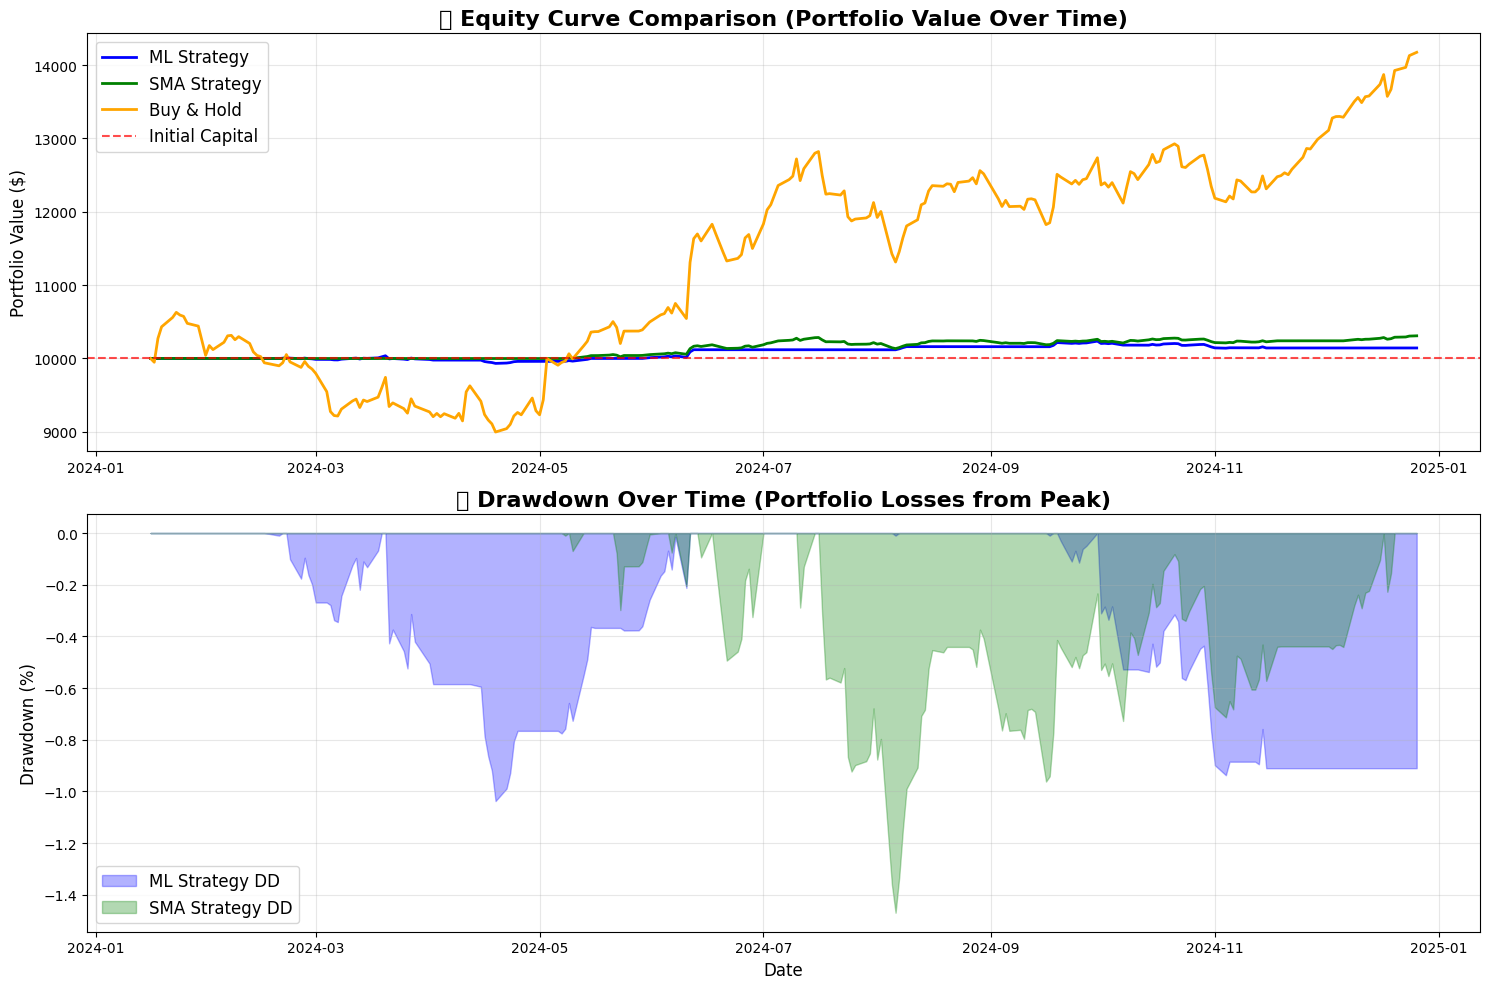

In [9]:

has_ml_history = 'portfolio_history' in results_lr and results_lr['portfolio_history'] is not None
has_sma_history = 'portfolio_history' in results_sma and results_sma['portfolio_history'] is not None

portfolio_ml = results_lr['portfolio_history']['portfolio_value']
portfolio_sma = results_sma['portfolio_history']['portfolio_value']
dates = results_lr['portfolio_history'].index

initial_capital = 10000
test_prices_clean = test_data['Close']
buy_hold_returns = test_prices_clean.pct_change().fillna(0)
buy_hold_equity = initial_capital * (1 + buy_hold_returns).cumprod()

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(dates, portfolio_ml, label='ML Strategy', linewidth=2, color='blue')
plt.plot(dates, portfolio_sma, label='SMA Strategy', linewidth=2, color='green')
plt.plot(test_data.index, buy_hold_equity.values, label='Buy & Hold', linewidth=2, color='orange')
plt.axhline(y=initial_capital, color='red', linestyle='--', alpha=0.7, label='Initial Capital')

plt.title('📈 Equity Curve Comparison (Portfolio Value Over Time)', fontsize=16, fontweight='bold')
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Drawdow
plt.subplot(2, 1, 2)
running_max_ml = portfolio_ml.expanding().max()
drawdown_ml = (portfolio_ml - running_max_ml) / running_max_ml * 100

running_max_sma = portfolio_sma.expanding().max()
drawdown_sma = (portfolio_sma - running_max_sma) / running_max_sma * 100

plt.fill_between(dates, drawdown_ml, 0, alpha=0.3, color='blue', label='ML Strategy DD')
plt.fill_between(dates, drawdown_sma, 0, alpha=0.3, color='green', label='SMA Strategy DD')

plt.title('📉 Drawdown Over Time (Portfolio Losses from Peak)', fontsize=16, fontweight='bold')
plt.ylabel('Drawdown (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [10]:


if 'buy_hold_return' not in locals():
    initial_capital = 10000
    start_price = test_data['Close'].iloc[0]
    end_price = test_data['Close'].iloc[-1]
    buy_hold_return = (end_price - start_price) / start_price
    buy_hold_final_value = initial_capital * (1 + buy_hold_return)
    
    buy_hold_returns = test_data['Close'].pct_change().fillna(0)
    buy_hold_sharpe = buy_hold_returns.mean() / buy_hold_returns.std() * np.sqrt(252) if buy_hold_returns.std() > 0 else 0
    
    cumulative_returns = (1 + buy_hold_returns).cumprod()
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    buy_hold_max_drawdown = drawdown.min()

strategies_data = {
    'ML Strategy (Linear Regression)': {
        'Total Return (%)': results_lr.get('total_return', 0) * 100,
        'Sharpe Ratio': results_lr.get('sharpe_ratio', 0),
        'Max Drawdown (%)': results_lr.get('max_drawdown', 0) * 100,
        'Total Trades': results_lr.get('total_trades', 0),
        'Win Rate': results_lr.get('win_rate', 0),
        'Final Value ($)': results_lr.get('final_value', 0)
    },
    'SMA Strategy': {
        'Total Return (%)': results_sma.get('total_return', 0) * 100,
        'Sharpe Ratio': results_sma.get('sharpe_ratio', 0),
        'Max Drawdown (%)': results_sma.get('max_drawdown', 0) * 100,
        'Total Trades': results_sma.get('total_trades', 0),
        'Win Rate': results_sma.get('win_rate', 0),
        'Final Value ($)': results_sma.get('final_value', 0)
    },
    'Buy & Hold': {
        'Total Return (%)': buy_hold_return * 100,
        'Sharpe Ratio': buy_hold_sharpe,
        'Max Drawdown (%)': buy_hold_max_drawdown * 100,
        'Total Trades': 1,
        'Win Rate': 1.0 if buy_hold_return > 0 else 0.0,
        'Final Value ($)': buy_hold_final_value
    }
}

comparison_df = pd.DataFrame(strategies_data).T
print("\nCOMPARISON TABLE:")
print(comparison_df.round(2))

print(f"\nBEST PERFORMERS:")
print(f"Highest Return: {comparison_df['Total Return (%)'].idxmax()} ({comparison_df['Total Return (%)'].max():.2f}%)")
print(f"Best Sharpe Ratio: {comparison_df['Sharpe Ratio'].idxmax()} ({comparison_df['Sharpe Ratio'].max():.3f})")
print(f"Lowest Drawdown: {comparison_df['Max Drawdown (%)'].idxmin()} ({comparison_df['Max Drawdown (%)'].min():.2f}%)")
print(f"Highest Final Value: {comparison_df['Final Value ($)'].idxmax()} (${comparison_df['Final Value ($)'].max():,.2f})")



COMPARISON TABLE:
                                 Total Return (%)  Sharpe Ratio  \
ML Strategy (Linear Regression)              1.43          1.05   
SMA Strategy                                 3.09          1.66   
Buy & Hold                                  41.75          1.74   

                                 Max Drawdown (%)  Total Trades  Win Rate  \
ML Strategy (Linear Regression)             -1.04          18.0       0.5   
SMA Strategy                                -1.47           5.0       0.5   
Buy & Hold                                 -15.35           1.0       1.0   

                                 Final Value ($)  
ML Strategy (Linear Regression)         10143.01  
SMA Strategy                            10308.66  
Buy & Hold                              14174.64  

BEST PERFORMERS:
Highest Return: Buy & Hold (41.75%)
Best Sharpe Ratio: Buy & Hold (1.736)
Lowest Drawdown: Buy & Hold (-15.35%)
Highest Final Value: Buy & Hold ($14,174.64)


/var/folders/4s/hdt7mcyn7m90dndlj9zm7p5c0000gq/T/ipykernel_79968/3178488570.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/hdt7mcyn7m90dndlj9zm7p5c0000gq/T/ipykernel_79968/3178488570.py:32: UserWarning: Glyph 128737 (\N{SHIELD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/hdt7mcyn7m90dndlj9zm7p5c0000gq/T/ipykernel_79968/3178488570.py:32: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/urdzik/Developer/SET/Intro to deep learning/Capstone Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/urdzik/Developer/SET/Intro to deep learning/Capstone Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128737 (\N{SHIELD}) missin

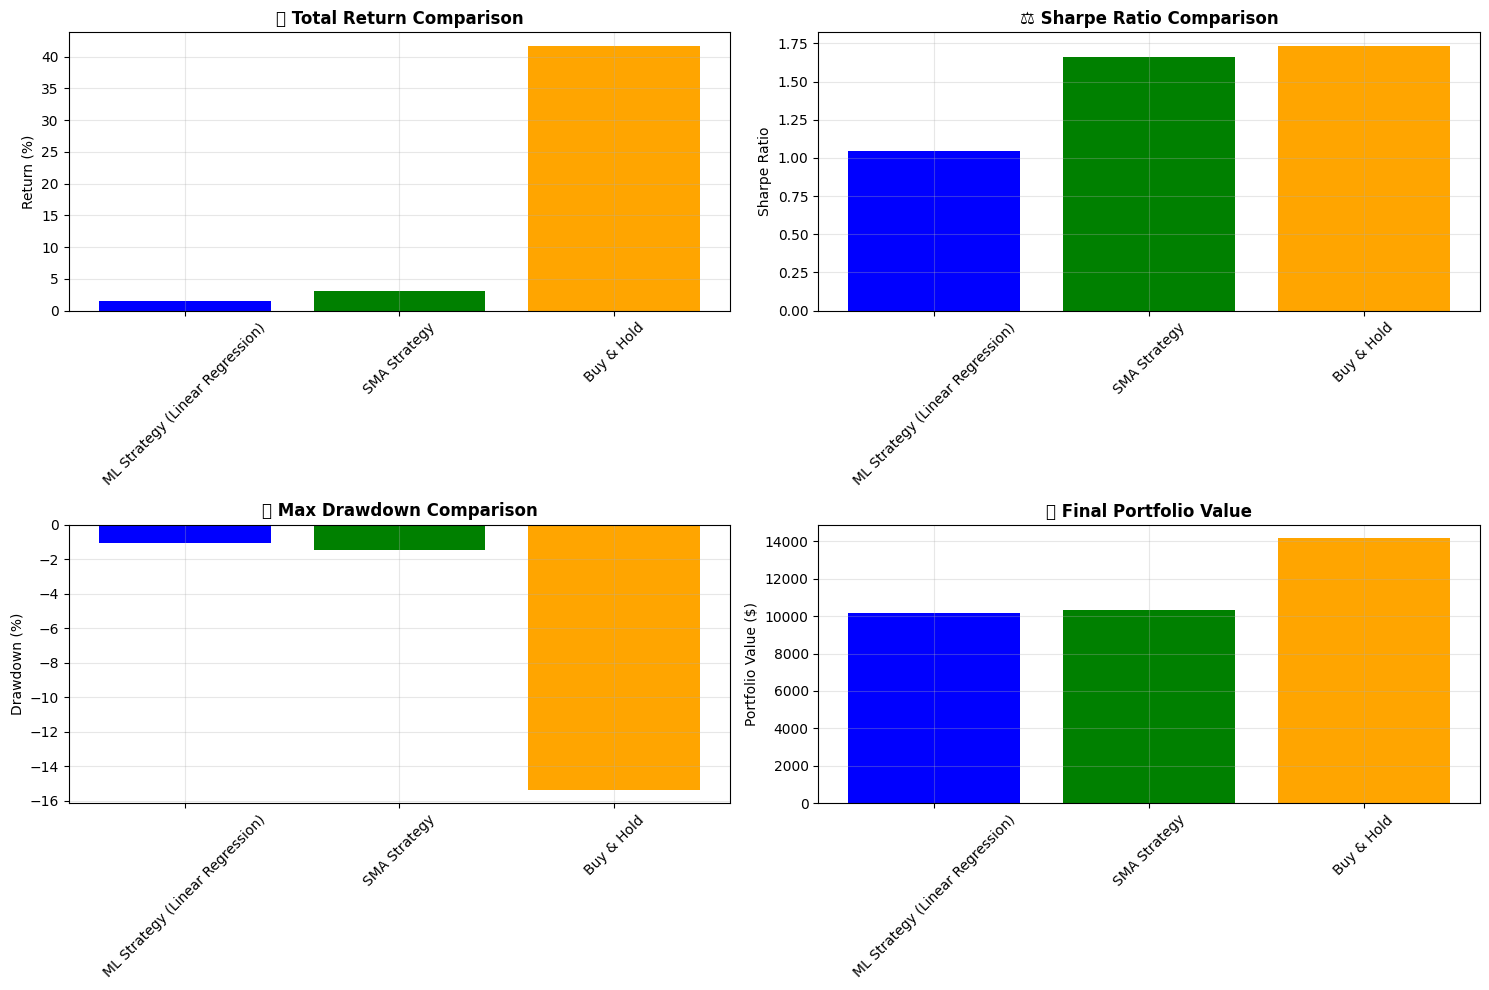

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

returns = comparison_df['Total Return (%)']
axes[0, 0].bar(comparison_df.index, returns, color=['blue', 'green', 'orange'])
axes[0, 0].set_title('📈 Total Return Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

sharpe = comparison_df['Sharpe Ratio']
axes[0, 1].bar(comparison_df.index, sharpe, color=['blue', 'green', 'orange'])
axes[0, 1].set_title('⚖️ Sharpe Ratio Comparison', fontweight='bold')
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

drawdown = comparison_df['Max Drawdown (%)']
axes[1, 0].bar(comparison_df.index, drawdown, color=['blue', 'green', 'orange'])
axes[1, 0].set_title('🛡️ Max Drawdown Comparison', fontweight='bold')
axes[1, 0].set_ylabel('Drawdown (%)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)


final_values = comparison_df['Final Value ($)']
axes[1, 1].bar(comparison_df.index, final_values, color=['blue', 'green', 'orange'])
axes[1, 1].set_title('💰 Final Portfolio Value', fontweight='bold')
axes[1, 1].set_ylabel('Portfolio Value ($)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()